### Import Libraries

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [95]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [96]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [97]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [98]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [99]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "M"

In [100]:
df_M = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "M"].copy()
df_M

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
2216,2022-07-26,ACHMAD YANI,JL JEND SUDIRMAN,DAMAI,BALIKPAPAN SELATAN,LAKI-LAKI,1980-06-22,Wiraswasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MA0,M,INDIVIDU,44
2262,2022-08-08,NURUL HASANAH,JL. SEPAKU LAUT GANG RUKUN,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-02-02,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,36
2267,2022-08-10,HERU BADRUDIN,PERUM GRIYA PERMATA ASRI JL.MC KENZIE,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1988-03-05,Pegawai Swasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,37
2472,2022-09-19,RISWAN FEBRIYANTO BATARA,JL. DAKSA TIMUR XIII,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1994-02-25,Pegawai Swasta-Pertanian,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,31
2513,2022-09-23,PT HARAPAN UTAMA MAKMUR,JL MT HARYONO,DAMAI,BALIKPAPAN KOTA,NaN,1979-07-18,NaN,NaN,NaN,MB0,M,INSTANSI LUAR,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,2024-08-31,DODI PRATAMA SUHARSO,BATU AMPAR PERMAL,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1989-11-03,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,ML0,M,INDIVIDU,35
6851,2024-08-31,SUSAN HADINATA,JL. S. PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1983-09-20,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MD1,M,INDIVIDU,41
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47


Plot data initial varian plus "M"

In [101]:
df_M_count = df_M[["Tgl. Mohon"]].copy()
df_M_count["count"] = 1.
df_M_count = df_M_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_M_count["cumulative_sum"] = df_M_count["count"].cumsum()
# df_M_count.to_csv("df_M_count.csv", index=False)
df_M_count

,Tgl. Mohon,count,cumulative_sum
0,2022-07-26,1,1
1,2022-08-08,1,2
2,2022-08-10,1,3
3,2022-09-19,1,4
4,2022-09-23,2,6
...,...,...,...
283,2024-08-27,2,510
284,2024-08-28,5,515
285,2024-08-29,6,521
286,2024-08-30,3,524


Groub by weekly

In [102]:
df_M_weekly = df_M_count[["Tgl. Mohon"]].copy()
df_M_count["Tgl. Mohon"] = pd.to_datetime(df_M_count["Tgl. Mohon"])

df_M_weekly = (df_M.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_M_weekly["cumulative_sum"] = df_M_weekly["count"].cumsum()
# df_M_weekly.to_csv("df_M_weekly.csv", index=False)
df_M_weekly


,Tgl. Mohon,count,cumulative_sum
0,2022-08-01,1,1
1,2022-08-08,1,2
2,2022-08-15,1,3
3,2022-08-22,0,3
4,2022-08-29,0,3
...,...,...,...
105,2024-08-05,24,440
106,2024-08-12,24,464
107,2024-08-19,23,487
108,2024-08-26,21,508


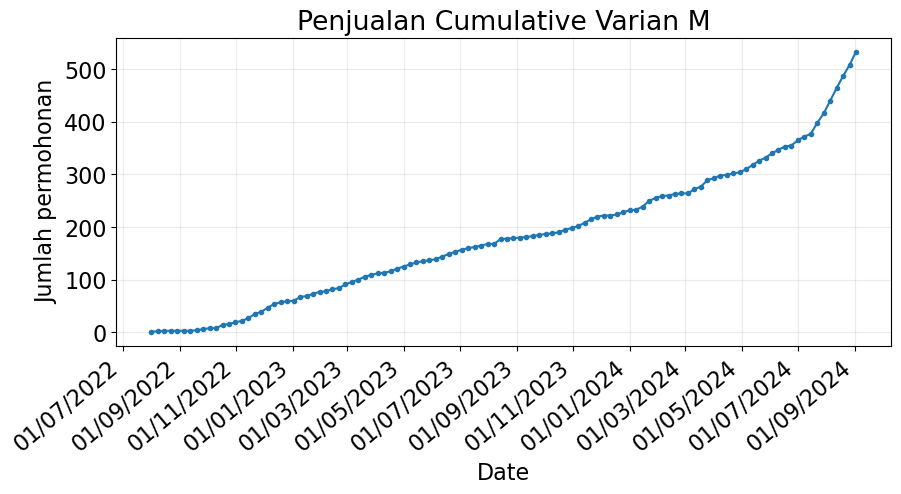

In [103]:
plot_time_series(df_M_weekly["Tgl. Mohon"], df_M_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian M",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [104]:
ADF_result = adfuller(df_M_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.929118037610138
p-value: 0.9934587984456482


first diff (_d_=1)

In [105]:
M_diff_week = np.diff(df_M_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(M_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 2.695370871497768
p-value: 0.9990867608734134


sec diff (_d_=2)

In [106]:
M_diff2_week = np.diff(M_diff_week, n=1)
ADF_result2 = adfuller(M_diff2_week)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")

ADF statistic : -16.30269744850517
p-value : 3.254331433028201e-29


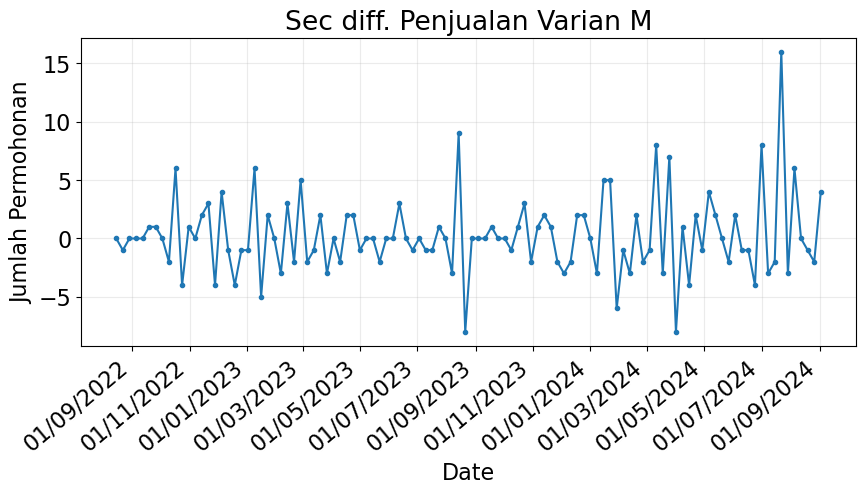

In [107]:
plot_time_series(df_M_weekly["Tgl. Mohon"].iloc[2:], M_diff2_week, 
                 title="Sec diff. Penjualan Varian M",
                 xlabel="Date", ylabel="Jumlah Permohonan")

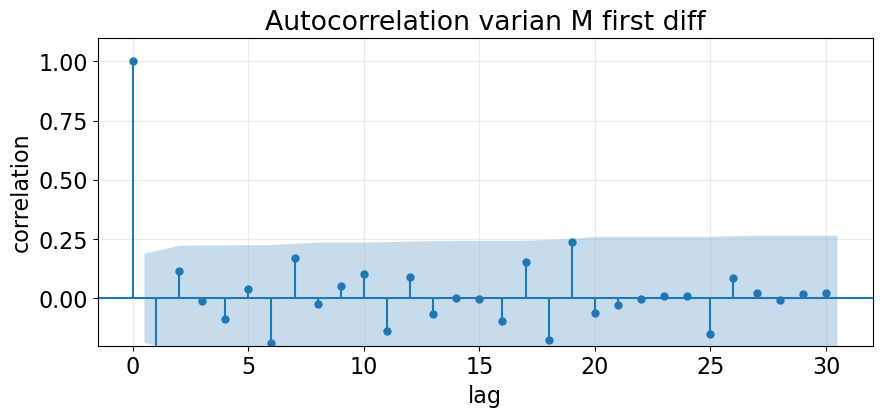

In [108]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(M_diff2_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian M first diff")
ax.grid("on")

plt.show(fig)

#### harian

In [109]:
ADF_result = adfuller(df_M_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 3.489172049094733
p-value: 1.0


fisrt diff (_d_=1)

In [110]:
M_diff = np.diff(df_M_count["cumulative_sum"], n=1)
ADF_result = adfuller(M_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.0053684628810498
p-value: 0.2842241876023269


sec diff (d=2)

In [111]:
M_diff2 = np.diff(df_M_count["cumulative_sum"], n=2)
ADF_result2 = adfuller(M_diff2)
print(f"ADF statistic: {ADF_result2[0]}")
print(f"p-value: {ADF_result2[1]}")

ADF statistic: -7.513728042629534
p-value: 3.953321715225474e-11


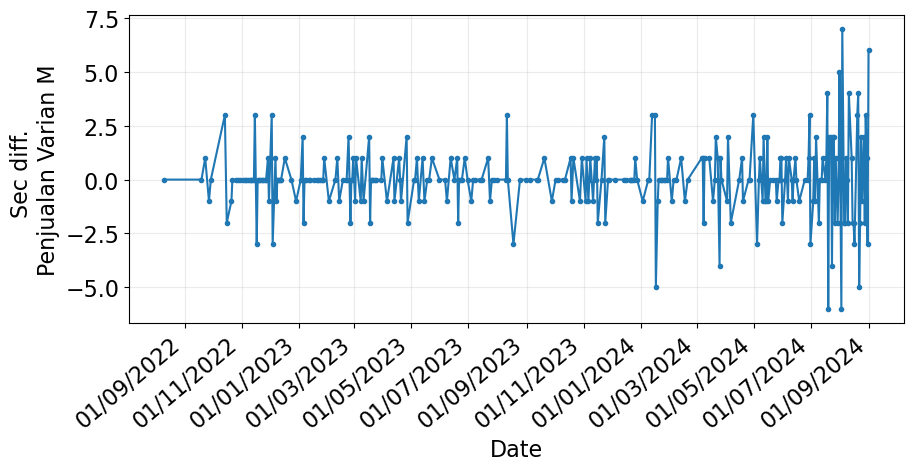

In [112]:
plot_time_series(df_M_count["Tgl. Mohon"].iloc[2:], M_diff2, 
                #  title="First diff. Penjualan Varian M",
                 xlabel="Date", ylabel="Sec diff. \nPenjualan Varian M")

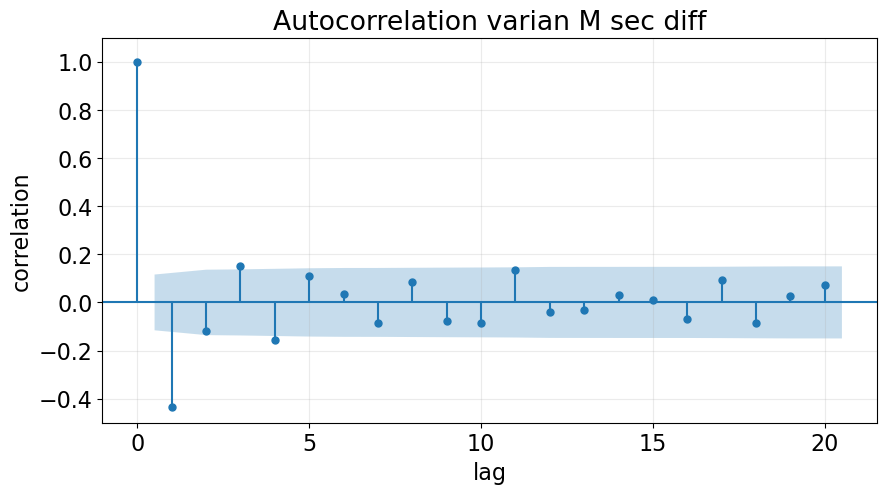

In [122]:
fig, ax = plt.subplots(figsize=(10, 5))

fig = plot_acf(M_diff2, lags=20, ax=ax)

ax.set_ylim([-.5, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian M sec diff")
ax.grid("on")

plt.show(fig)

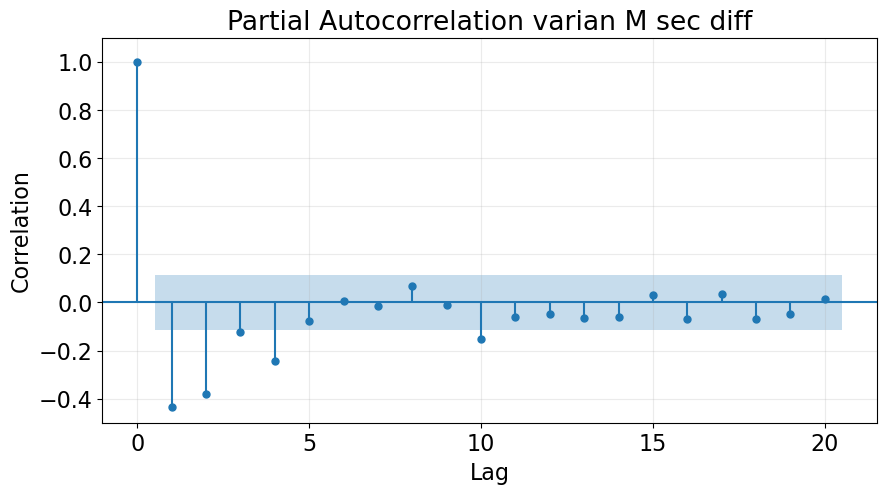

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_pacf(M_diff2, lags=20, ax=ax)

ax.set_ylim([-0.5, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian M sec diff")
ax.grid("on")

plt.show()

In [115]:
advanced_decomposition = STL(df_M_count["cumulative_sum"], period=12).fit()
advanced_decomposition

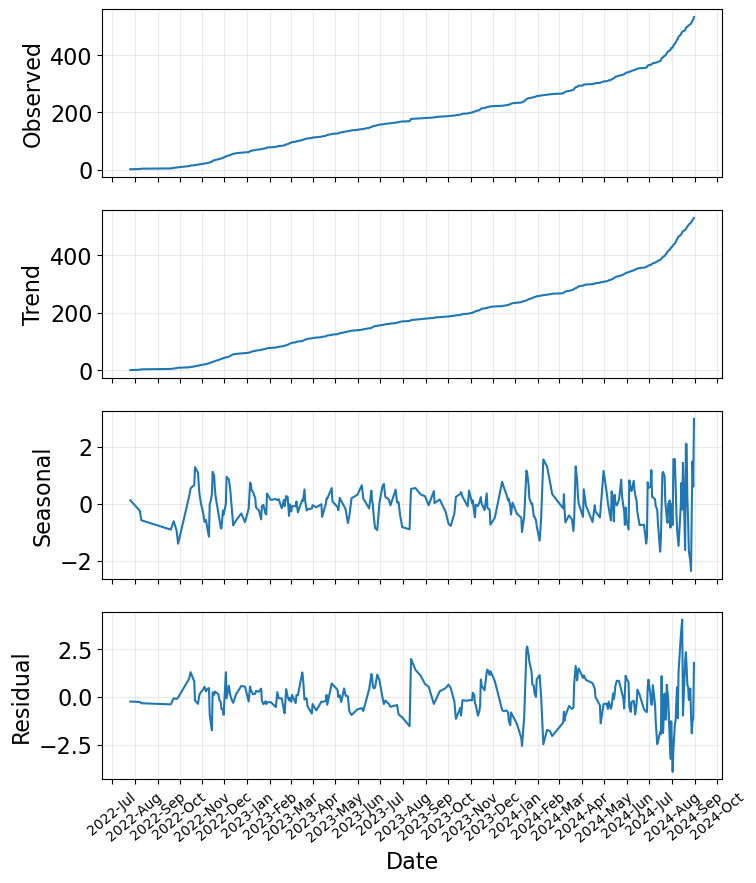

In [116]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

axes[0].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.observed)
axes[1].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.trend)
axes[2].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.seasonal)
axes[3].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.resid)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].xaxis.set_major_locator(locator)

for label in axes[3].get_xticklabels():
  label.set_rotation(40)
  label.set_size(10)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

### Data Splitting

In [117]:
split_idx = int(0.8 * len(df_M_count))
df_train = df_M_count.iloc[:split_idx].copy()
df_test = df_M_count.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (230, 58)


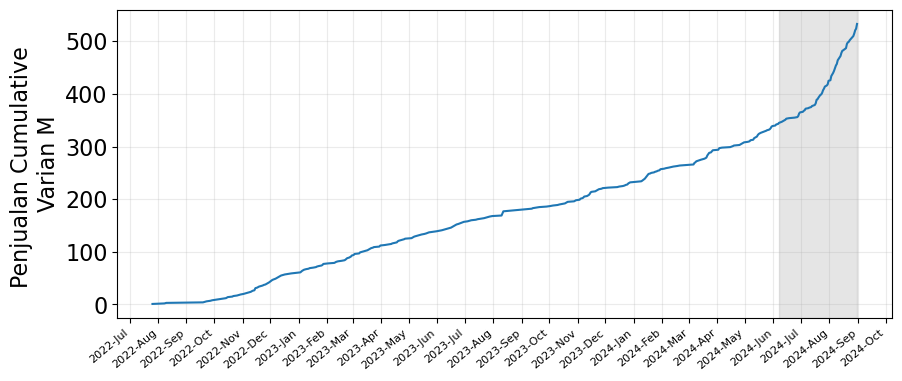

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_M_count['Tgl. Mohon'], df_M_count["cumulative_sum"])
ax.grid("on")
ax.set_ylabel("Penjualan Cumulative \nVarian M")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (1,1,2)

In [158]:
p_space = range(0, 13, 1)  # set 0 to 12 to capture seasonal information
q_space = range(0, 13, 1)
P_space = [0]   # set P and Q to 0 because we are working with ARIMA(p,d,q)
Q_space = [0]

d = 2
D = 0   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

arima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(arima_order_list)}")
arima_order_list

num. of possible paramters setting: 169


[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

In [159]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [160]:
# Computational time: 3m 6.5s
# arima_result_df = optimize_SARIMA(df_train["cumulative_sum"], arima_order_list, d,
#                            D, m, enforce_invertibility=True, enforce_stationarity=True)

  0%|          | 0/169 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\

In [161]:
# arima_result_df.to_csv("./data/varian-m-arima-result.csv", index=False)

In [162]:
reload_arima_result_df = pd.read_csv("./data/varian-m-arima-result.csv")
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(0, 2, 0, 0)",588.703879
1,"(2, 3, 0, 0)",588.964727
2,"(1, 1, 0, 0)",588.981954
3,"(3, 3, 0, 0)",589.066142
4,"(1, 3, 0, 0)",589.579561
...,...,...
164,"(4, 0, 0, 0)",628.523703
165,"(3, 0, 0, 0)",634.533227
166,"(2, 0, 0, 0)",645.341246
167,"(1, 0, 0, 0)",669.528894


In [163]:
# arima_result_df
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(0, 2, 0, 0)",588.703879
1,"(2, 3, 0, 0)",588.964727
2,"(1, 1, 0, 0)",588.981954
3,"(3, 3, 0, 0)",589.066142
4,"(1, 3, 0, 0)",589.579561
...,...,...
164,"(4, 0, 0, 0)",628.523703
165,"(3, 0, 0, 0)",634.533227
166,"(2, 0, 0, 0)",645.341246
167,"(1, 0, 0, 0)",669.528894


In [164]:
# best_pqPQ = reload_arima_result_df["(p,q,P,Q)"].iloc[1]
# best_arima_p, best_arima_q, _, _ = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

best ARIMA (p,q): (2, 3)


In [240]:
best_arima_p, best_arima_q = (1, 1)
print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

best ARIMA (p,q): (1, 1)


In [241]:
model_arima_best = SARIMAX(df_train["cumulative_sum"], order=(best_arima_p, d, best_arima_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

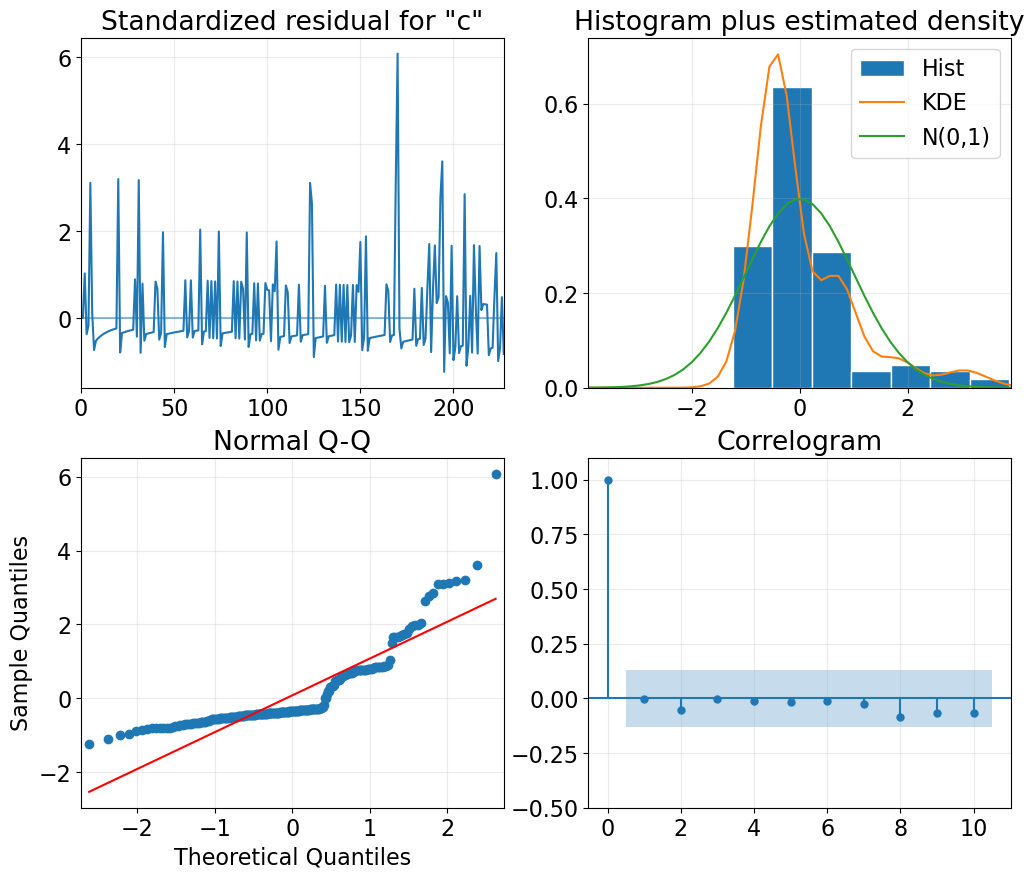

In [242]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [243]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.001386,0.970305
2,0.746780,0.688397
3,0.746916,0.862117
4,0.770116,0.942409
5,0.890840,0.970881
6,0.900182,0.989115
7,0.918954,0.996032
8,2.730065,0.950139
9,4.009143,0.910810
10,5.162843,0.880038


- Pada semua lag nilai p-value lebih besar dari 0.05, maka kita tidak reject the null hypothesis pada setiap lag.
- Artinya residual bersifat independen dan tidak berkorelasi, sehingga residual dari model ARIMA dianggap sebagai white noise dan model sudah cukup baik dalam menangkap pola data.

In [244]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

pred_naive_seasonal = df_train["cumulative_sum"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()

,Tgl. Mohon,count,cumulative_sum,pred_naive_seasonal,pred_arima
230,2024-06-07,2,345,246,344.580956
231,2024-06-10,2,347,248,346.231957
232,2024-06-11,1,348,249,347.891403
233,2024-06-12,1,349,250,349.551868
234,2024-06-14,2,351,251,351.212455


### SARIMA

In [245]:
p_space = range(0, 4, 1)  
q_space = range(0, 4, 1)
P_space = range(0, 4, 1)   
Q_space = range(0, 4, 1)

d = 2
D = 1   
m = 12

sarima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarima_order_list)}")
sarima_order_list

num. of possible paramters setting: 256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [246]:
# Computational time: 11m 46.6s
# sarima_result_df = optimize_SARIMA(df_train["cumulative_sum"], sarima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [247]:
# sarima_result_df.to_csv("./data/varian-m-sarima-result.csv", index=False)

In [248]:
reload_sarima_result_df = pd.read_csv("./data/varian-m-sarima-result.csv")
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(0, 2, 1, 1)",582.120559
1,"(0, 2, 0, 3)",582.136653
2,"(1, 1, 1, 1)",582.172366
3,"(0, 2, 2, 1)",582.937344
4,"(1, 1, 2, 1)",583.070378
...,...,...
251,"(0, 0, 1, 0)",725.395453
252,"(3, 0, 0, 0)",733.404635
253,"(2, 0, 0, 0)",745.191492
254,"(1, 0, 0, 0)",760.999860


In [249]:
# sarima_result_df
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(0, 2, 1, 1)",582.120559
1,"(0, 2, 0, 3)",582.136653
2,"(1, 1, 1, 1)",582.172366
3,"(0, 2, 2, 1)",582.937344
4,"(1, 1, 2, 1)",583.070378
...,...,...
251,"(0, 0, 1, 0)",725.395453
252,"(3, 0, 0, 0)",733.404635
253,"(2, 0, 0, 0)",745.191492
254,"(1, 0, 0, 0)",760.999860


In [250]:
# best_pqPQ = reload_sarima_result_df["(p,q,P,Q)"].iloc[0]
# best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
#   = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

In [251]:
best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
  = (1, 1, 1, 1)
print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

best SARIMA (p,q,P,Q): (1, 1, 1, 1)


In [252]:
model_sarima_best = SARIMAX(df_train["cumulative_sum"], order=(best_sarima_p, d, best_sarima_q), 
                            seasonal_order=(best_sarima_P, D, best_sarima_Q, m),
                            simple_differencing=False)
model_sarima_best_fit = model_sarima_best.fit(disp=False)

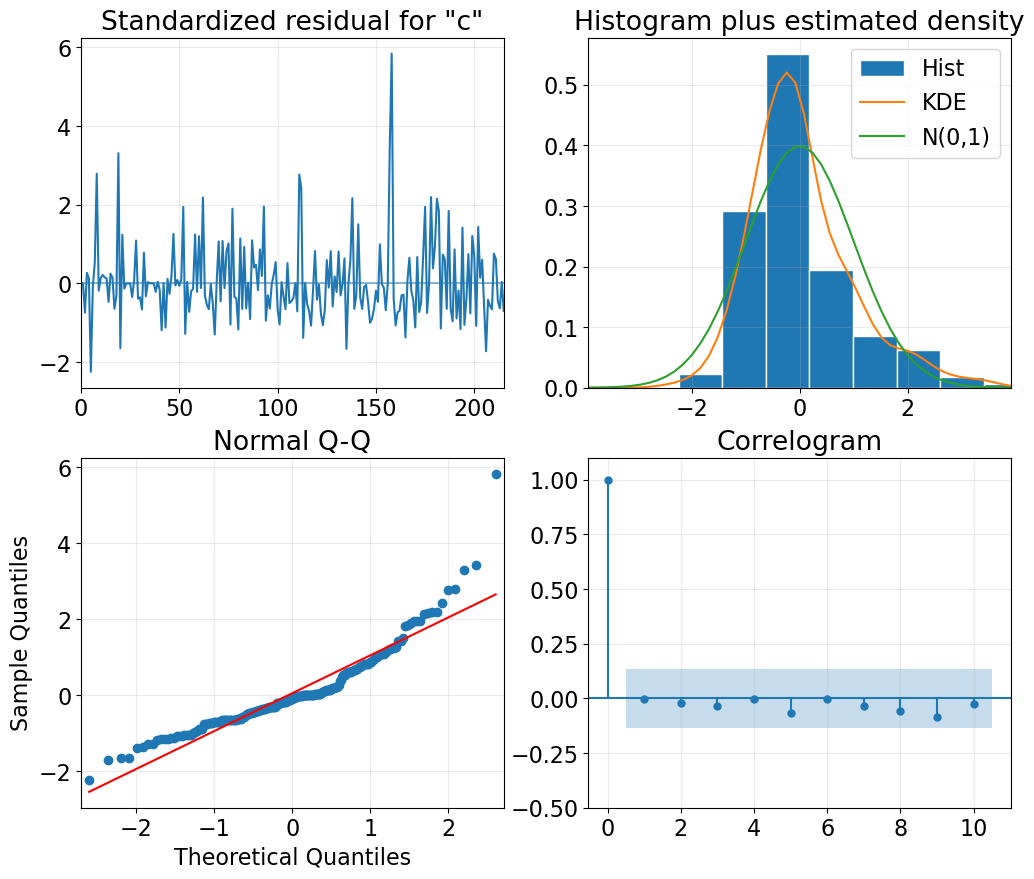

In [253]:
fig = model_sarima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [254]:
residuals = model_sarima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.277972,0.598034
2,0.949752,0.621962
3,0.987503,0.804276
4,1.008389,0.908521
5,2.136886,0.829898
6,2.160150,0.904396
7,2.163035,0.950268
8,2.801387,0.946197
9,5.420915,0.796182
10,5.480293,0.856876


Karena semua nilai p-value lebih besar dari 0.05, kita dapat menyimpulkan bahwa residual dari model yang diuji tidak memiliki autokorelasi yang signifikan, sehingga model sudah cukup baik dalam menangkap pola dalam data.

In [255]:
pred_sarima = model_sarima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_sarima"] = pred_sarima
df_test_pred

,Tgl. Mohon,count,cumulative_sum,pred_naive_seasonal,pred_arima,pred_sarima
230,2024-06-07,2,345,246,344.580956,344.342153
231,2024-06-10,2,347,248,346.231957,346.404164
232,2024-06-11,1,348,249,347.891403,349.916120
233,2024-06-12,1,349,250,349.551868,351.302805
234,2024-06-14,2,351,251,351.212455,352.699587
235,2024-06-15,2,353,252,352.873057,354.387248
236,2024-06-18,1,354,253,354.533661,355.800718
237,2024-06-24,1,355,254,356.194265,358.431089
238,2024-06-27,1,356,255,357.854869,359.907395
239,2024-06-28,2,358,257,359.515473,361.322588


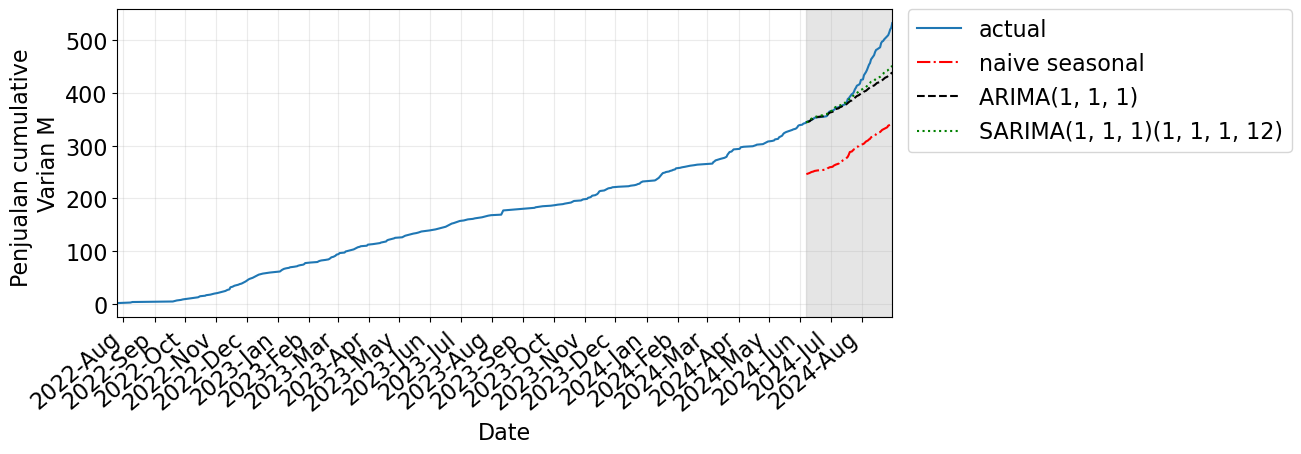

In [269]:
start_idx = 0  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["cumulative_sum"])
ax.plot(df_test["Tgl. Mohon"], df_test["cumulative_sum"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan cumulative \nVarian M")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 1)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(1, 1, 1)(1, 1, 1, 12)")
(1, 1, 1, 1)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
#   label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

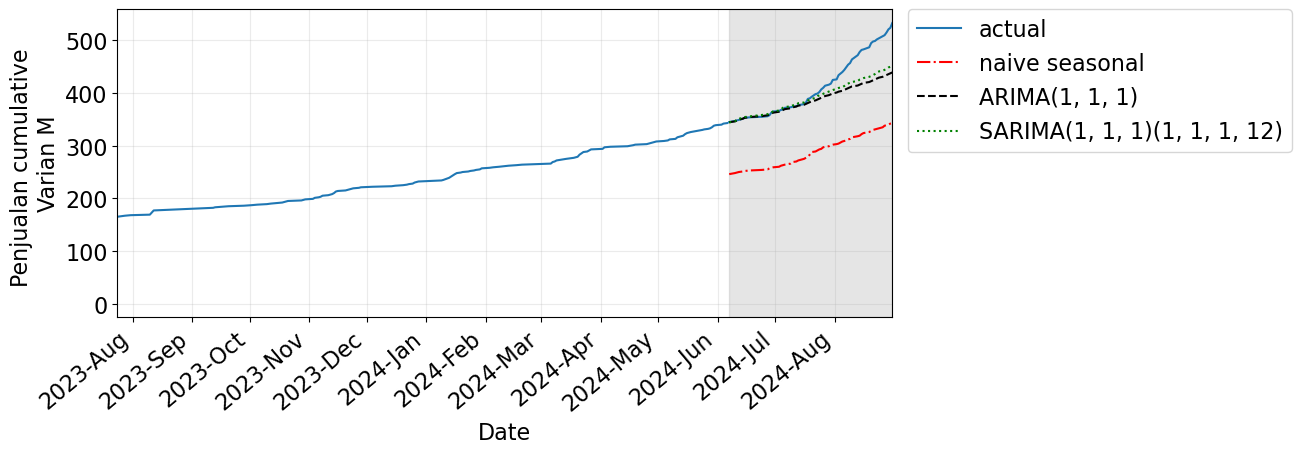

In [268]:
start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["cumulative_sum"])
ax.plot(df_test["Tgl. Mohon"], df_test["cumulative_sum"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan cumulative \nVarian M")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 1)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(1, 1, 1)(1, 1, 1, 12)")
(1, 1, 1, 1)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
#   label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi

In [258]:
mae_naive_seasonal = mean_absolute_error(df_test_pred["cumulative_sum"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["cumulative_sum"], df_test_pred["pred_arima"])
mae_sarima         = mean_absolute_error(df_test_pred["cumulative_sum"], df_test_pred["pred_sarima"])

print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"         MAE ARIMA: {mae_arima}")
print(f"        MAE SARIMA: {mae_sarima}")

MAE naive seasonal: 127.93103448275862
         MAE ARIMA: 29.321932561354636
        MAE SARIMA: 24.362896837042626


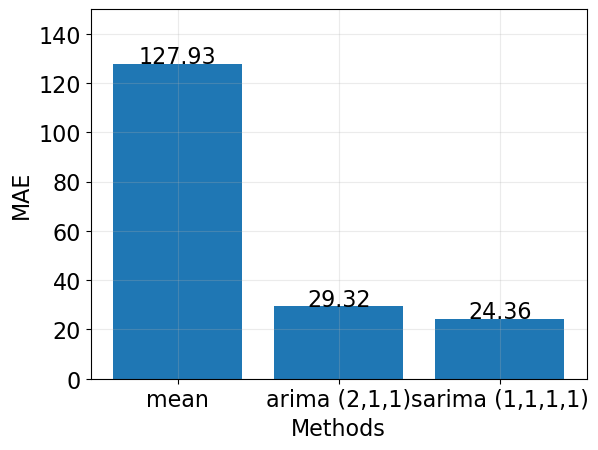

In [259]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mae_naive_seasonal, mae_arima, mae_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 150])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [260]:
mse_naive_seasonal  = mean_squared_error(df_test_pred["cumulative_sum"], df_test_pred["pred_naive_seasonal"])
mse_arima  = mean_squared_error(df_test_pred["cumulative_sum"], df_test_pred["pred_arima"])
mse_sarima = mean_squared_error(df_test_pred["cumulative_sum"], df_test_pred["pred_sarima"])

print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE arima: {mse_arima}")
print(f"MSE sarima: {mse_sarima}")

MSE naive seasonal: 17176.931034482757
MSE arima: 1804.6377374629276
MSE sarima: 1284.2949844278255


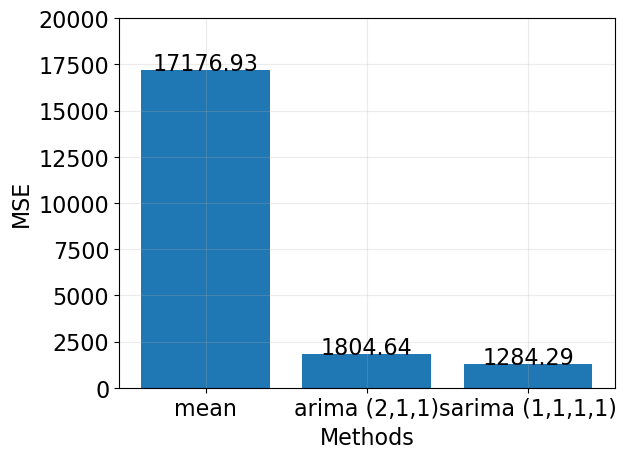

In [261]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mse_naive_seasonal, mse_arima, mse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 20000])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [262]:
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)
rmse_sarima         = np.sqrt(mse_sarima)

print(f"RMSE mean: {rmse_naive_seasonal}")
print(f"RMSE arima: {rmse_arima}")
print(f"RMSE sarima: {rmse_sarima}")

RMSE mean: 131.06079136981722
RMSE arima: 42.481027970882806
RMSE sarima: 35.83706160426417


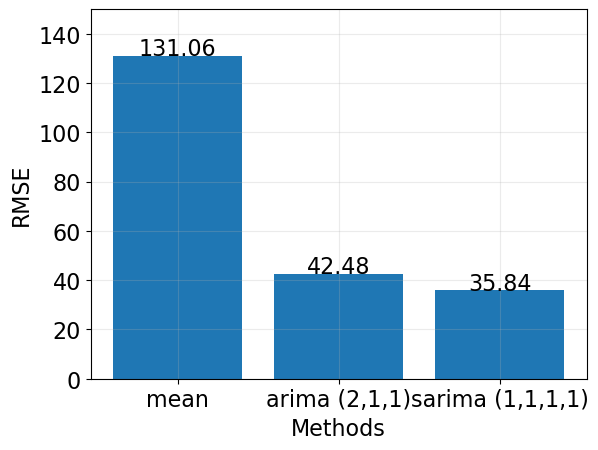

In [263]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [rmse_naive_seasonal, rmse_arima, rmse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 150])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [264]:
mape_naive_seasonal = mean_absolute_percentage_error(df_test_pred["cumulative_sum"], df_test_pred["pred_naive_seasonal"]) * 100 
mape_arima          = mean_absolute_percentage_error(df_test_pred["cumulative_sum"], df_test_pred["pred_arima"]) * 100
mape_sarima         = mean_absolute_percentage_error(df_test_pred["cumulative_sum"], df_test_pred["pred_sarima"]) * 100

print(f"MAPE naive seasonal: {mape_naive_seasonal:5.2f}%")
print(f"         MAPE ARIMA: {mape_arima:5.2f}%")
print(f"        MAPE SARIMA: {mape_sarima:5.2f}%")

MAPE naive seasonal: 30.07%
         MAPE ARIMA:  6.14%
        MAPE SARIMA:  5.09%


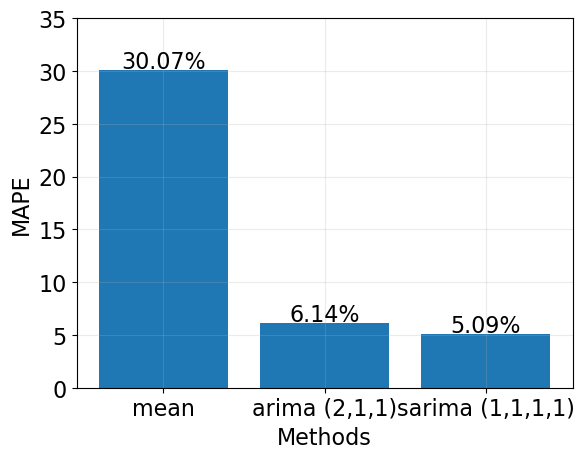

In [265]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mape_naive_seasonal, mape_arima, mape_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 35])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

In [266]:
naive = np.abs(np.diff(df_train["cumulative_sum"])).mean()

mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima = mae_arima / naive
mase_sarima  = mae_sarima / naive

print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE arima: {mase_arima}")
print(f"MASE sarima: {mase_sarima}")

MASE naive seasonal: 85.66142367412785
MASE arima: 19.633691685819333
MASE sarima: 16.313167765154272


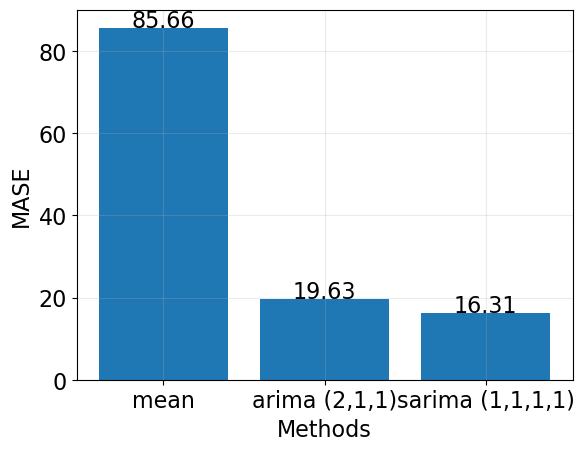

In [267]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mase_naive_seasonal, mase_arima, mase_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 90])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)